<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE2] - First VAE, using a subclass model (MNIST dataset)
<!-- DESC --> Construction and training of a VAE, using model subclass, with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a still more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.models    import VAE
from modules.layers    import SamplingLayer
from modules.callbacks import ImagesCallback, BestModelCallback
from modules.datagen   import MNIST

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/VAE2.005'
datasets_dir = pwk.init('VAE2', run_dir)

VAE.about()

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.21
Notebook id          : VAE2
Run time             : Sunday 21 March 2021, 22:37:10
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE2.005
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE2.005/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.4
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


## Step 2 - Parameters
`scale` : With scale=1, we need 1'30s on a GPU V100 ...and >20' on a CPU !\
`latent_dim` : 2 dimensions is small, but usefull to draw !


`loss_weights` : Our **loss function** is the weighted sum of two loss:
 - `r_loss` which measures the loss during reconstruction.  
 - `kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where : `total_loss = k1*r_loss + k2*kl_loss`  
In practice, a value of \[1,6e-4\] gives good results here.


In [2]:
latent_dim    = 2
loss_weights  = [1,6e-4]

scale         = 1
seed          = 123

batch_size    = 64
epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('latent_dim', 'loss_weights', 'scale', 'seed', 'batch_size', 'epochs')

## Step 3 - Prepare data
`MNIST.get_data()` return : `x_train,y_train, x_test,y_test`,  \
but we only need x_train for our training.

Seeded (123)
Dataset loaded.
Concatenated.
Shuffled.
rescaled (1).
Normalized.
Reshaped.
splited (1).
x_train shape is  :  (70000, 28, 28, 1)
x_test  shape is  :  (0, 28, 28, 1)
y_train shape is  :  (70000,)
y_test  shape is  :  (0,)
Blake2b digest is :  0c903710d4d28b01c174


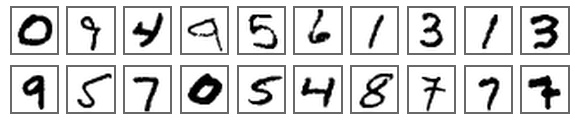

In [4]:
x_data, y_data, _,_ = MNIST.get_data(seed=seed, scale=scale, train_prop=1 )

pwk.plot_images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')

## Step 4 - Build model
In this example, we will use a **custom model**.
For this, we will use :
 - `SamplingLayer`, which generates a vector z from the parameters z_mean and z_log_var - See : [SamplingLayer.py](./modules/layers/SamplingLayer.py)
 - `VAE`, a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()

#### VAE
`VAE` is a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

In [7]:
vae = VAE(encoder, decoder, loss_weights)

vae.compile(optimizer='adam')

Fidle VAE is ready :-)  loss_weights=[1, 0.0006]


## Step 5 - Train
### 5.1 - Using two nice custom callbacks :-)
Two custom callbacks are used:
 - `ImagesCallback` : qui va sauvegarder des images durant l'apprentissage - See [ImagesCallback.py](./modules/callbacks/ImagesCallback.py)
 - `BestModelCallback` : qui sauvegardera le meilleur model - See [BestModelCallback.py](./modules/callbacks/BestModelCallback.py)

In [8]:
callback_images      = ImagesCallback(x=x_data, z_dim=latent_dim, nb_images=5, from_z=True, from_random=True, run_dir=run_dir)
callback_bestmodel   = BestModelCallback( run_dir + '/models/best_model.h5' )
callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel]

### 5.2 - Let's train !
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
pwk.chrono_start()

history = vae.fit(x_data, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10
1094/1094 [==============================] - 9s 5ms/step - loss: 0.2261 - r_loss: 0.2234 - kl_loss: 0.0026
Epoch 2/10
1094/1094 [==============================] - 5s 4ms/step - loss: 0.1927 - r_loss: 0.1901 - kl_loss: 0.0026
Epoch 3/10
1094/1094 [==============================] - 5s 4ms/step - loss: 0.1876 - r_loss: 0.1850 - kl_loss: 0.0026
Epoch 4/10
1094/1094 [==============================] - 5s 4ms/step - loss: 0.1849 - r_loss: 0.1823 - kl_loss: 0.0026
Epoch 5/10
1094/1094 [==============================] - 5s 4ms/step - loss: 0.1828 - r_loss: 0.1802 - kl_loss: 0.0026
Epoch 6/10
1094/1094 [==============================] - 5s 4ms/step - loss: 0.1813 - r_loss: 0.1786 - kl_loss: 0.0026
Epoch 7/10
1094/1094 [==============================] - 5s 4ms/step - loss: 0.1799 - r_loss: 0.1773 - kl_loss: 0.0026
Epoch 8/10
1094/1094 [==============================] - 5s 4ms/step - loss: 0.1791 - r_loss: 0.1764 - kl_loss: 0.0027
Epoch 9/10
1094/1094 [==============================] - 

## Step 6 - Training review
### 6.1 - History

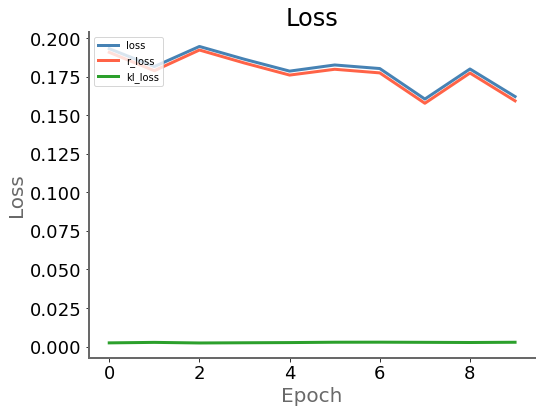

In [10]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

<br>**Original images :**

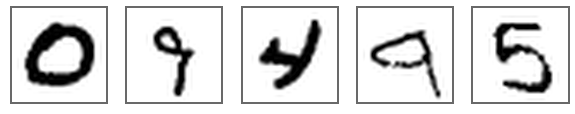

<br>**Encoded/decoded images**

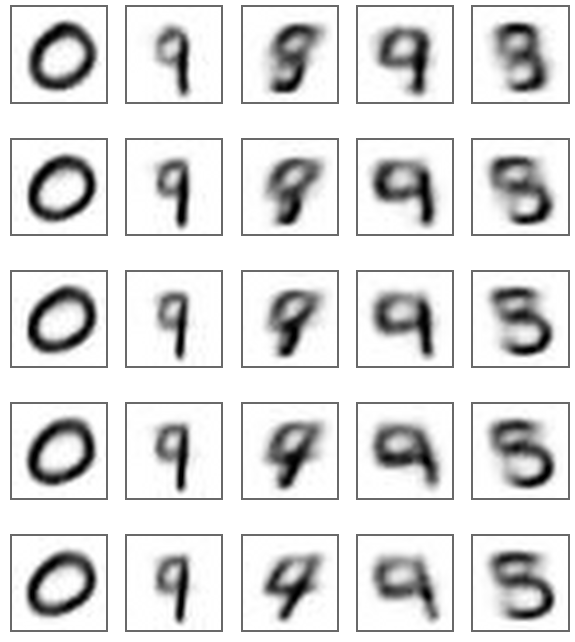

<br>**Original images :**

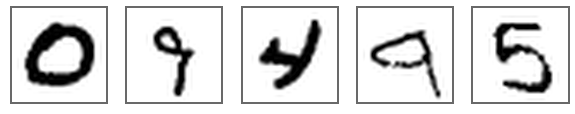

In [11]:
images_z, images_r = callback_images.get_images( range(0,epochs,2) )

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-original')

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(images_z, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder) during training

<br>**Generated images from latent space**

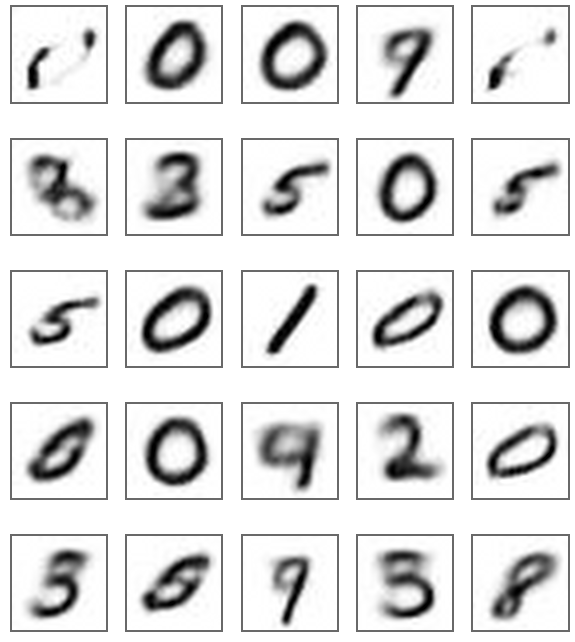

In [12]:
pwk.subtitle('Generated images from latent space')
pwk.plot_images(images_r, None, indices='all', columns=5, x_size=2,y_size=2, save_as='04-encoded')

## Step 7 - Model evaluation

### 7.1 - Reload best model

In [13]:
vae=VAE()
vae.reload(f'{run_dir}/models/best_model')

Fidle VAE is ready :-)  loss_weights=[1, 1]
Reloaded.


### 7.2 - Image reconstruction

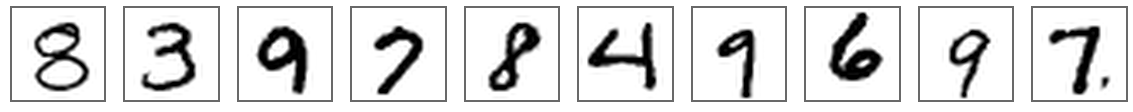

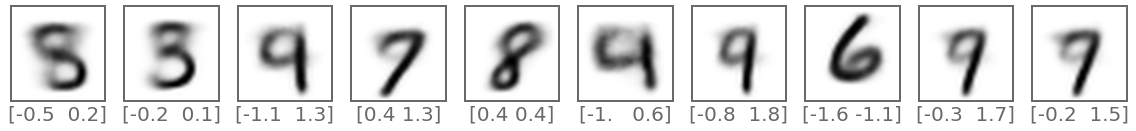

In [14]:
# ---- Select few images

x_show = pwk.pick_dataset(x_data, n=10)

# ---- Get latent points and reconstructed images

z_mean, z_var, z  = vae.encoder.predict(x_show)
x_reconst         = vae.decoder.predict(z)

# ---- Show it

labels=[ str(np.round(z[i],1)) for i in range(10) ]
pwk.plot_images(x_show,    None, indices='all', columns=10, x_size=2,y_size=2, save_as='05-original')
pwk.plot_images(x_reconst, labels  , indices='all', columns=10, x_size=2,y_size=2, save_as='06-reconstruct')


### 7.3 - Visualization of the latent space

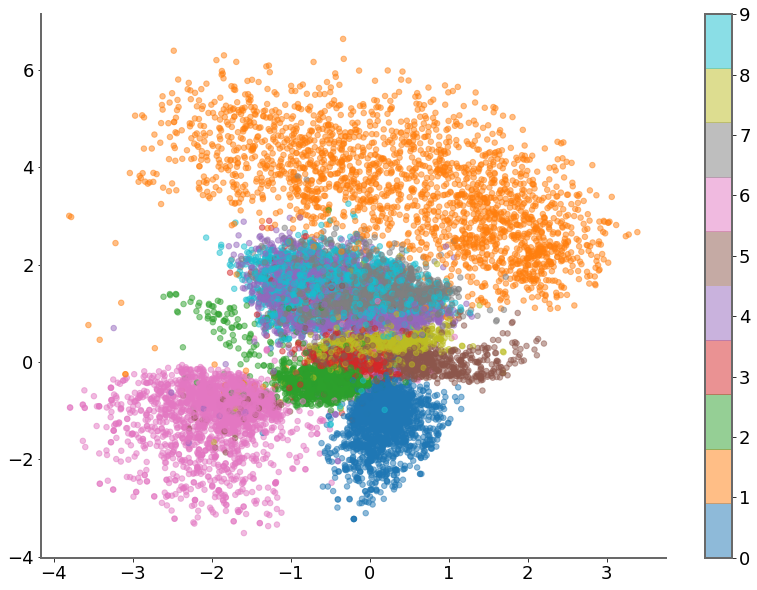

In [15]:
n_show = 20000

# ---- Select images

x_show, y_show = pwk.pick_dataset(x_data,y_data, n=n_show)

# ---- Get latent points

z_mean, z_var, z = vae.encoder.predict(x_show)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
pwk.save_fig('07-Latent-space')
plt.show()

### 7.4 - Generative latent space

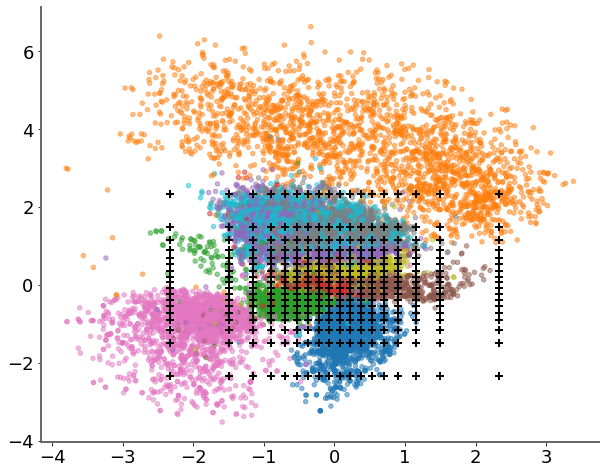

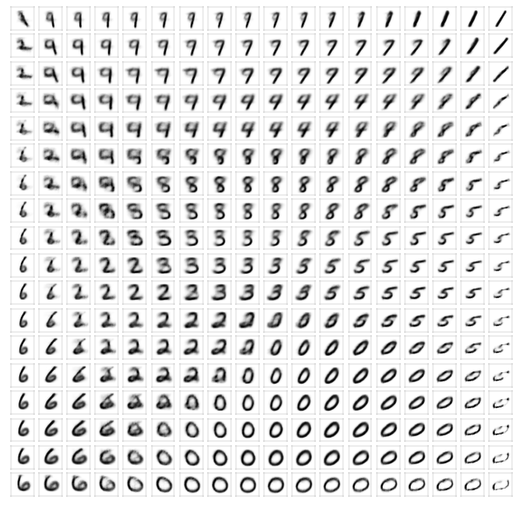

In [16]:
grid_size   = 18
grid_scale  = 1

# ---- Draw a ppf grid

grid=[]
for y in scipy.stats.norm.ppf(np.linspace(0.99, 0.01, grid_size),scale=grid_scale):
    for x in scipy.stats.norm.ppf(np.linspace(0.01, 0.99, grid_size),scale=grid_scale):
        grid.append( (x,y) )
grid=np.array(grid)

# ---- Draw latentspoints and grid

fig = plt.figure(figsize=(10, 8))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=20)
plt.scatter(grid[:, 0] , grid[:, 1], c = 'black', s=60, linewidth=2, marker='+', alpha=1)
pwk.save_fig('08-Latent-grid')
plt.show()

# ---- Plot grid corresponding images

x_reconst = vae.decoder.predict([grid])
pwk.plot_images(x_reconst, indices='all', columns=grid_size, x_size=0.5,y_size=0.5, y_padding=0,spines_alpha=0.1, save_as='09-Latent-morphing')



In [17]:
pwk.end()

End time is : Sunday 21 March 2021, 22:38:59
Duration is : 00:01:49 240ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>